In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from itertools import combinations  

In [5]:
sns.set_theme(style="whitegrid")

In [6]:
data_dtypes = {"Name": str, "Age": "Int16", "Martial Status": str, "Education Level": str, "Number of Children": "Int16","Smoking Status": str, "Physical Activity Level": str, "Employment Status": str, "Alcohol Consumption": str, "Dietary Habits": str, "Sleep Patterns": str, "History of Mental Illness": str, "History of Substance Abuse": str, "Family History of Depression": str, "Chronic Medical Conditions": str}
df = pd.read_csv("../data/depression_data.csv", dtype=data_dtypes)

target_var = "History of Mental Illness"

In [7]:
df.shape

(413768, 16)

In [8]:
df.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [9]:
df.isnull().sum()

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

The dataset does not have missing values. No missing handle method is required.

In [10]:
numerical_columns = df.select_dtypes(exclude=[object]).columns

df[numerical_columns].describe()

,Age,Number of Children,Income
count,413768.0,413768.0,413768.000000
mean,49.000713,1.298972,50661.707971
std,18.158759,1.237054,40624.100565
min,18.0,0.0,0.410000
25%,33.0,0.0,21001.030000
50%,49.0,1.0,37520.135000
75%,65.0,2.0,76616.300000
max,80.0,4.0,209995.220000


The scale seems to be very different between `Income` and other numerical features, standardization may be required if this feature is used in modelling.

<Axes: xlabel='History of Mental Illness', ylabel='Percent'>

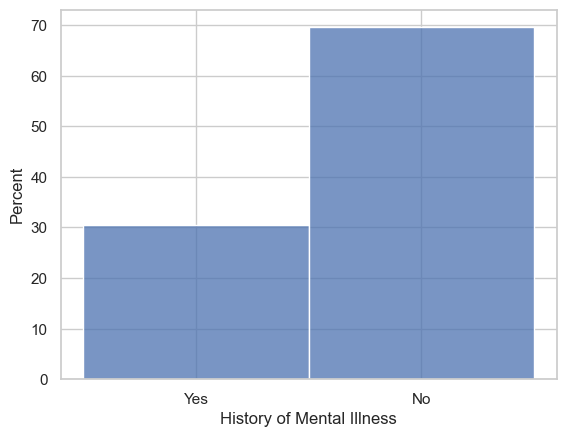

In [11]:
sns.histplot(data=df[target_var], stat="percent")

The distribution of target variable `History of Mental illness` shows that this class is inbalanced, with 30% of `Yes` and 70% of `No` class.

In [12]:
df[numerical_columns].corr()

,Age,Number of Children,Income
Age,1.000000,0.259268,-0.065628
Number of Children,0.259268,1.000000,0.028737
Income,-0.065628,0.028737,1.000000


The correlation coefficients between numerical features are computed, no strong correlation on each possible pair of numerical features are found.

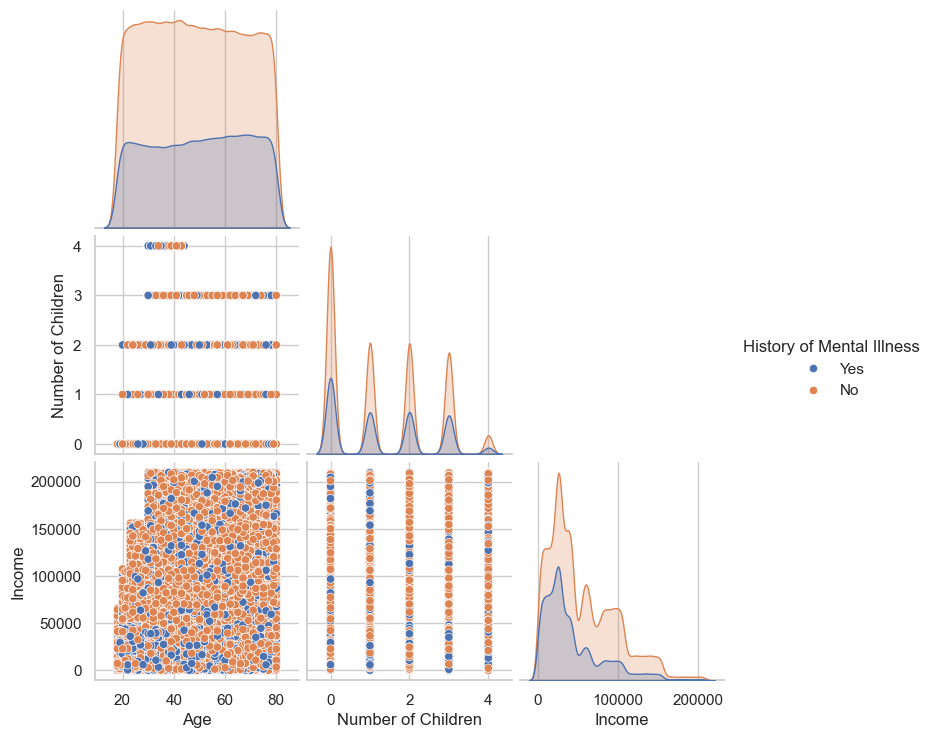

In [13]:
sns.pairplot(df[numerical_columns.tolist() + [target_var]], hue=target_var, corner=True)

The pairplots are created between each numerical features, with separation on the target variable. The diagnal graphs are the marginal distribution for each numerical features, and the lower triangle plots are the scatter plot using one feature against another. It seems the marginal distribution separation looks similar in shape but since the number of `No` target class is much higher, the distribution is generally higher than the one for `yes` class. It is very interesting to see the people with 4 children within this dataset has Age between late 30 and early 40. The distribution of `Income` seems to have a bit log normal shape.

In [14]:
categorical_columns = df.select_dtypes(include=[object]).columns

# drop Name column as it is a unique ID, it won't help with EDA or models
categorical_columns = categorical_columns.drop("Name")
categorical_columns = categorical_columns.drop(target_var)



In [15]:
# try to understand all unique values for each categorical column
for one_col in categorical_columns:
    print(f"{one_col}: {df[one_col].unique().tolist()}")

# create dictionary and provide order of feature values
categorical_col_variable_order = {
    "Marital Status": ["Married", "Widowed", "Divorced", "Single"],
    "Education Level": ["High School", "Associate Degree", "Bachelor's Degree", "Master's Degree", "PhD"],
    "Smoking Status": ["Non-smoker", "Former", "Current"],
    "Physical Activity Level": ["Sedentary", "Moderate", "Active"],
    "Employment Status": ["Unemployed", "Employed"],
    "Alcohol Consumption": ["Low", "Moderate", "High"],
    "Dietary Habits": [ "Unhealthy", "Moderate", "Healthy"],
    "Sleep Patterns": ["Poor", "Fair", "Good"],
    "History of Substance Abuse": ["No", "Yes"],
    "Family History of Depression": ["No", "Yes"],
    "Chronic Medical Conditions": ["No", "Yes"],
}

for one_col in categorical_columns:
    df[one_col] = pd.Categorical(df[one_col], categorical_col_variable_order[one_col])


Marital Status: ['Married', 'Widowed', 'Divorced', 'Single']
Education Level: ["Bachelor's Degree", 'High School', "Master's Degree", 'Associate Degree', 'PhD']
Smoking Status: ['Non-smoker', 'Former', 'Current']
Physical Activity Level: ['Active', 'Sedentary', 'Moderate']
Employment Status: ['Unemployed', 'Employed']
Alcohol Consumption: ['Moderate', 'High', 'Low']
Dietary Habits: ['Moderate', 'Unhealthy', 'Healthy']
Sleep Patterns: ['Fair', 'Good', 'Poor']
History of Substance Abuse: ['No', 'Yes']
Family History of Depression: ['Yes', 'No']
Chronic Medical Conditions: ['Yes', 'No']


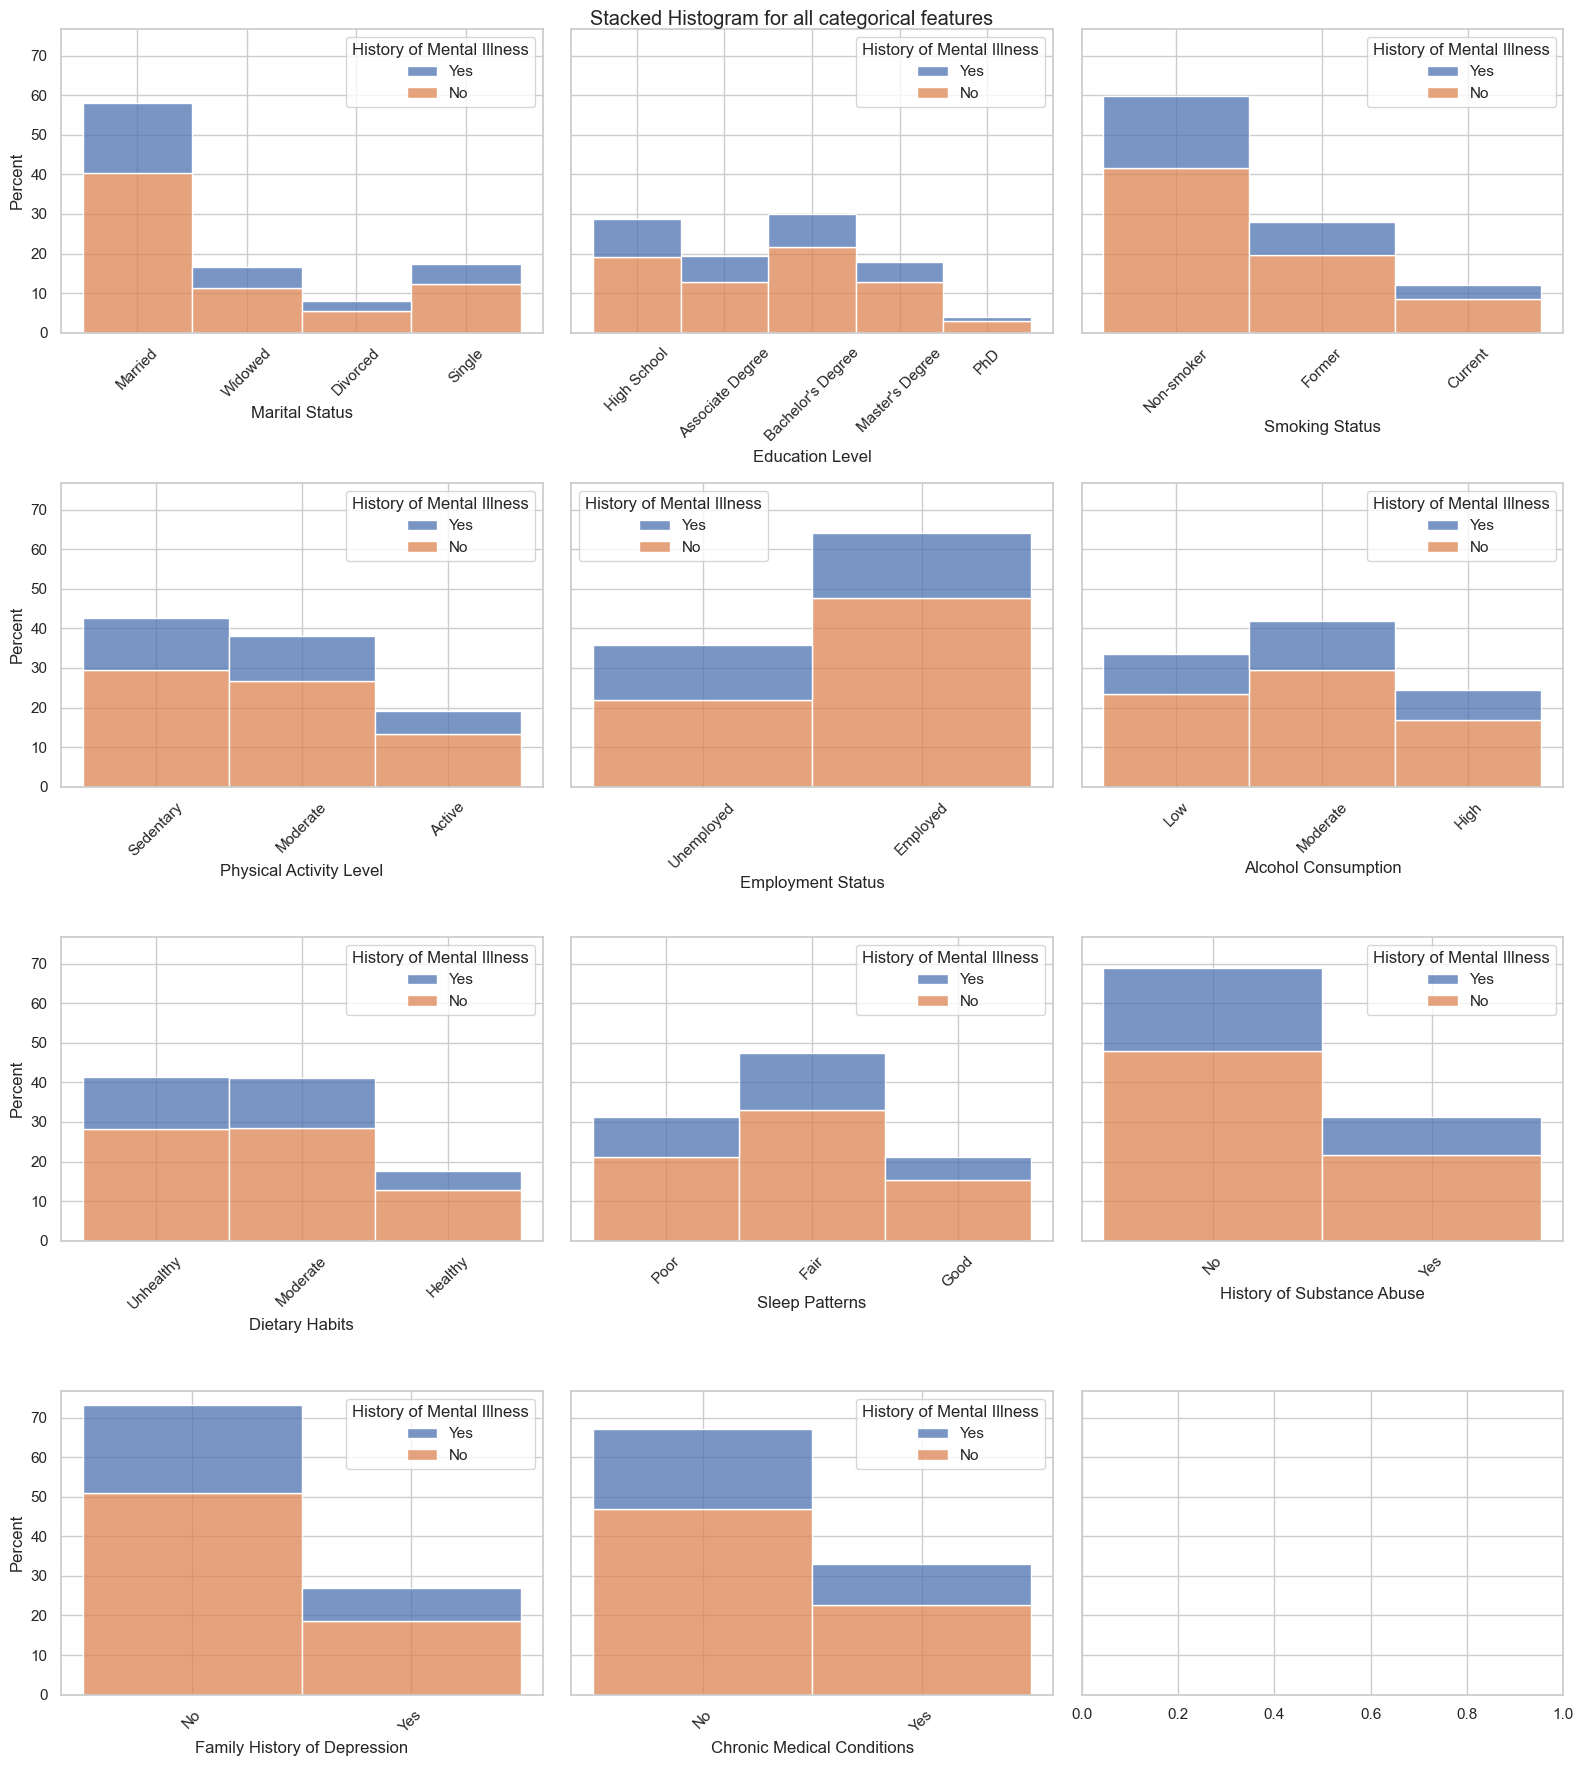

In [16]:
figure, axes = plt.subplots(4, 3, sharex=False, sharey=True, figsize=(16,18))
figure.suptitle('Stacked Histogram for all categorical features')

i = 0
j = 0
for one_col in categorical_columns:
    sns.histplot(ax=axes[i, j], data=df, x=one_col, hue=target_var, multiple="stack", stat="percent")
    axes[i, j].tick_params(axis='x', labelrotation=45)
    j += 1
    if j == 3:
        j = 0
        i += 1

plt.tight_layout()


The stacked histogram of each categorical feature is created with separation on target variables. Overall, it seems the target var distributed to each feature value relatively even. There are few categorical features seems to be very similar:
1. `Alcohol Consumption` - `Sleep Patterns`
2. `Physical Activity Level` - `Dietary Habits`
3. `History of Substance Abuse` - `Family History of Depression` - `Chronic Medical Conditions`

Chi squared test could be used to test if the categorical features are independent.

In [17]:
# pairwise_list = list(combinations(categorical_columns, 2))
pairwise_list = [["Alcohol Consumption", "Sleep Patterns"], ["Physical Activity Level", "Dietary Habits"], ["History of Substance Abuse", "Family History of Depression"], ["History of Substance Abuse", "Chronic Medical Conditions"], ["Family History of Depression", "Chronic Medical Conditions"]]

chi2_test_df = []

for var1, var2 in pairwise_list:
    ct_table_ind=pd.crosstab(df[var1],df[var2])

    chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)

    chi2_test_df.append((var1, var2, chi2_stat, p, dof))

result = pd.DataFrame.from_records(chi2_test_df, columns=["variable1", "variable2", "test_stats", "p_value", "dof"])

In [18]:
result

,variable1,variable2,test_stats,p_value,dof
0,Alcohol Consumption,Sleep Patterns,849.769835,1.270917e-182,4
1,Physical Activity Level,Dietary Habits,68296.074305,0.000000e+00,4
2,History of Substance Abuse,Family History of Depression,4.546132,3.299320e-02,1
3,History of Substance Abuse,Chronic Medical Conditions,4.509337,3.371031e-02,1
4,Family History of Depression,Chronic Medical Conditions,2.128509,1.445813e-01,1


After running chi squared test between the categorical columns seems to be similar from histogram plot, it seems all combinations there is significant evidence to reject null hypothesis. It means all pairwise combination of features seems be dependent to each other. In this case, it may make sense to keep only one of the features since they provide the same information.

## Summary of EDA

The csv downloaded from Kaggle website contains 413768 rows and 16 columns. The `Name` column is the unique identifier, the `History of Mental Illness` column is consider as a target variable. There are three numerical columns, such as `Age` (Discrete), `Number of Children` (Discrete), and `Income` (Continuous), and the rest are categorical columns.

After a quick look at the descriptive statistics on the numerical columns, it seems `Income` has a very different scale compare to the other two numerical columns, and it forms a shape which is similar to log normal distribution, **standardization can be considered if we use them in the modelling**. The scatter graph of numerical feature against target variable visualizes that the two classes seems to be splitted all over the features. The pairwise correlation coefficients are computed, and they are close to 0. Hence there is no evidence on there existing linear relationship between any pairs of numerical features.

The histogram of the target shows that the class seems to be inbalanced. There are 30% `Yes` and 70% `No` class. This will be considered when splitting the training and test sets in the modelling.

For categorical columns, the stacked histograms plot is done for each categorical column with separation on target variable. However, there seems to be groups of categorical features histograms looks similar:

1. `Alcohol Consumption` - `Sleep Patterns`
2. `Physical Activity Level` - `Dietary Habits`
3. `History of Substance Abuse` - `Family History of Depression` - `Chronic Medical Conditions`

These 3 groups makes sense from understanding of the contents, that they are highly related. A chi square test is done for each pair of categorical features within 3 groups, and it seems all pairwise combination of features, there are significant evidence to reject the null hypothesis, hence they are dependent on each other. Feature selection will be considered as some of the categorical features, may have dependencies.
 